In [14]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
from shapely.geometry import Point, LineString
from python_tsp.exact import solve_tsp_dynamic_programming
import matplotlib.pyplot as plt
import numpy as np
import os

In [4]:
# Step 1: Fetch expanded street network (Toyosu + Shinonome + Ariake)
# Define bounding box covering all three areas
north, south, east, west = 35.67, 35.62, 139.83, 139.77  # Lat/lon bounds
G = ox.graph_from_bbox([west, south, east, north], network_type="drive")
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

In [5]:
# 2. Convert the graph to a GeoDataFrame of edges
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)

# 3. Save as GeoJSON
gdf_edges.to_file("../output/study_area.geojson", driver="GeoJSON")

In [6]:
gdf_nodes.to_file("../output/study_area_network_nodes.geojson", driver="GeoJSON")

In [7]:
gdf_stops = gpd.read_file("../output/cluster_25.geojson")

In [8]:
stops = [(point.y, point.x) for point in gdf_stops.geometry]

In [9]:
# Step 3: Snap stops to nearest road nodes
stop_nodes = []
for lat, lon in stops:
    node = ox.distance.nearest_nodes(G, lon, lat)
    stop_nodes.append(node)

In [10]:
# Step 4: Nearest Neighbor TSP
def nearest_neighbor_tsp(G, stop_nodes, start_node_idx=0):
    n = len(stop_nodes)
    unvisited = set(range(n))
    current = start_node_idx
    path = [current]
    unvisited.remove(current)
    total_time = 0

    while unvisited:
        next_node = min(unvisited, key=lambda x:
                        nx.shortest_path_length(G, stop_nodes[current], stop_nodes[x],
                                               weight='travel_time'))
        total_time += nx.shortest_path_length(G, stop_nodes[current], stop_nodes[next_node],
                                              weight='travel_time')
        path.append(next_node)
        unvisited.remove(next_node)
        current = next_node

    # Return to start
    total_time += nx.shortest_path_length(G, stop_nodes[current], stop_nodes[start_node_idx],
                                          weight='travel_time')
    path.append(start_node_idx)

    return path, total_time

path, total_time = nearest_neighbor_tsp(G, stop_nodes, start_node_idx=0)
optimal_stop_order = [stops[i] for i in path]

In [11]:
# Step 5: Calculate full route path along roads
route_nodes = []
route_coords = []
for i in range(len(path) - 1):  # Exclude last (duplicate of start)
    start_node = stop_nodes[path[i]]
    end_node = stop_nodes[path[i + 1]]
    segment = nx.shortest_path(G, start_node, end_node, weight='travel_time')
    route_nodes.extend(segment[:-1])  # Avoid duplicating nodes
    for node in segment:
        lon, lat = G.nodes[node]['x'], G.nodes[node]['y']
        route_coords.append((lat, lon))
route_nodes.append(route_nodes[0])  # Close the loop

In [ ]:
# Step 6: Convert to GeoDataFrame and save as GeoJSON
route_geometry = [LineString([(lon, lat) for lat, lon in route_coords])]
route_gdf = gpd.GeoDataFrame(geometry=route_geometry, crs="EPSG:4326")
route_gdf.to_file("../output/toyosu_shinonome_ariake_bus_route_nn.geojson", driver="GeoJSON")

stop_gdf = gpd.GeoDataFrame(
    {'order': range(len(optimal_stop_order))},
    geometry=[Point(lon, lat) for lat, lon in optimal_stop_order],
    crs="EPSG:4326"
)
stop_gdf.to_file("../output/toyosu_shinonome_ariake_bus_stops_nn.geojson", driver="GeoJSON")
print("Route and stops saved as GeoJSON files")

Route and stops saved as GeoJSON files


In [13]:
# Step 7: Print results
print("Nearest Neighbor Stop Order:")
for i, (lat, lon) in enumerate(optimal_stop_order):
    print(f"Stop {i+1}: ({lat}, {lon})")
total_time_min = total_time / 60
total_distance = sum(
    nx.shortest_path_length(G, stop_nodes[path[i]], stop_nodes[path[i + 1]],
                           weight='length')
    for i in range(len(path) - 1)
) / 1000  # Meters to km
print(f"Total Route Time: {total_time_min:.1f} minutes")
print(f"Total Route Distance: {total_distance:.2f} km")

Nearest Neighbor Stop Order:
Stop 1: (35.63118105115736, 139.79193163450688)
Stop 2: (35.631863398379046, 139.79730635120535)
Stop 3: (35.628778695179086, 139.7950512813964)
Stop 4: (35.63438464935425, 139.79214377405918)
Stop 5: (35.63815305736782, 139.79337918185226)
Stop 6: (35.639512584334206, 139.7898123221932)
Stop 7: (35.636278672342925, 139.7869809330593)
Stop 8: (35.63537592939371, 139.78219814581732)
Stop 9: (35.631304358607345, 139.78802355435204)
Stop 10: (35.642187981481484, 139.79500630851064)
Stop 11: (35.64297205492424, 139.80021090198863)
Stop 12: (35.63959917666079, 139.8031052680776)
Stop 13: (35.64494734016394, 139.8037993130123)
Stop 14: (35.648555444888444, 139.8019338947719)
Stop 15: (35.65147410002858, 139.79815470677337)
Stop 16: (35.65440958068732, 139.79587462796954)
Stop 17: (35.65625809041592, 139.79795789632308)
Stop 18: (35.65545003121349, 139.79282691937905)
Stop 19: (35.657471383728385, 139.79532383365364)
Stop 20: (35.651703340112206, 139.7935256058906

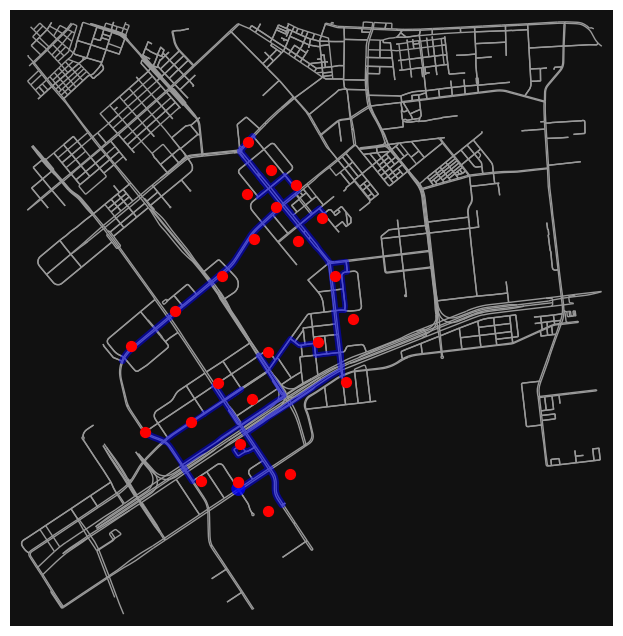

In [ ]:
# Visualize
fig, ax = ox.plot_graph_route(G, route_nodes, route_color='blue', node_size=0,
                              show=False, close=False)
stop_gdf.plot(ax=ax, color='red', markersize=50, zorder=3)
plt.show()